In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define lattice dimensions
nx, ny = 5, 5

# Define clusters and their coefficients
clusters = [    [[[0, 0], [1, 0]], 0.1],
    [[[0, 0], [0, 1]], 0.2],
    [[[0, 0], [1, 0], [0, 1]], -0.1],
]

# Define function to calculate the energy of a single cluster
def cluster_energy(cluster, coefficient, occupancy):
    energy = 0
    for c in cluster:
        cluster_energy = coefficient 
        for site in c:
            x, y = site
            if (x >= nx) or (y >= ny):
                cluster_energy = 0
                break
            if occupancy[x, y] == 0:
                cluster_energy = 0
                break
        energy += cluster_energy
    return energy

# Randomly set occupancy variables for each lattice site
occupancy = np.random.randint(0, 2, size=(nx, ny))

# Calculate the total energy and cluster energies
total_energy = 0
cluster_energies = []
for cluster, coefficient in clusters:
    energy = 0
    for i in range(nx):
        for j in range(ny):
            # Translate cluster to current position and calculate energy
            translated_cluster = [[np.array(site) + np.array([i, j]) for site in cluster]]
            energy += cluster_energy(translated_cluster, coefficient, occupancy)
    cluster_energies.append(energy)
    total_energy += energy

# Plot the lattice without clusters marked out
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
for i in range(nx):
    for j in range(ny):
        xy = np.array([[i, j], [i + 1, j], [i + 1, j + 1], [i, j + 1]])
        color = "k" if occupancy[i, j] else "none"
        poly = Polygon(xy, facecolor=color, edgecolor="k")
        ax.add_patch(poly)
ax.set_xlim(0, nx)
ax.set_ylim(0, ny)
ax.set_title("A 2d alloy")
plt.show()

# Plot each cluster individually
for i, (cluster, coefficient) in enumerate(clusters):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    for site in cluster:
        x, y = site[0]+nx/2.-1, site[1]+ny/2.-1
        xy = np.array([[x, y], [x + 1, y], [x + 1, y + 1], [x, y + 1]])
        color = "r"
        poly = Polygon(xy, facecolor=color, edgecolor="r")
        ax.add_patch(poly)
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_title("Cluster {} (coefficient {})".format(i+1, coefficient))
    plt.show()
print("The energy of the system is defined by the number of \n cluster of each type that you can fit over black pathes of the alloy.")

E_guess = input("What is the expected energy of the system?")


# Print total energy and cluster energies
print("True total energy: ", total_energy," Your guess?",E_guess)
for i, energy in enumerate(cluster_energies):
    print("Contribtion from cluster {} is {}".format(i+1, energy))

In [1]:
#@title Cluster expansion tutorial using Ice-T 
!curl -O https://icet.materialsmodeling.org/tutorial.zip
!unzip tutorial.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  166k  100  166k    0     0   562k      0 --:--:-- --:--:-- --:--:--  560k
Archive:  tutorial.zip
   creating: tutorial/
  inflating: tutorial/7_plot_monte_carlo_data.py  
  inflating: tutorial/__8_attach_observer_to_monte_carlo.py  
  inflating: tutorial/1_construct_cluster_expansion.py  
  inflating: tutorial/reference_data.db  
  inflating: tutorial/2_compare_to_target_data.py  
  inflating: tutorial/6_collect_monte_carlo_data.py  
  inflating: tutorial/3_enumerate_structures.py  
  inflating: tutorial/5b_run_monte_carlo_vcsgc.py  
  inflating: tutorial/5a_run_monte_carlo_sgc.py  
  inflating: tutorial/4_analyze_ecis.py  


In [2]:
!pip install icet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 KB 7.1 MB/s eta 0:00:00
  Created wheel for icet: filename=icet-2.2-cp39-cp39-linux_x86_64.whl size=7877100 sha256=40cc830bbc02e07b36039133fcac143c74dbd9b4397ac066b83129bedeb824db
  Stored in directory: /root/.cache/pip/wheels/f9/db/54/35d4db785561b62afc129becdbb075e3a674b10d732b4b7e98
Successfully built icet


In [ ]:
%cd tutorial

/content/tutorial


In [ ]:
from ase.db import connect
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator

# step 1: Basic setup
db = connect('reference_data.db')
primitive_structure = db.get(id=1).toatoms()  # primitive structure

# step 2: Set up the basic structure and a cluster space
cs = ClusterSpace(structure=primitive_structure,
                  cutoffs=[13.5, 6.5, 6.0],
                  chemical_symbols=['Ag', 'Pd'])
print(cs)

# step 3: Parse the input structures and set up a structure container
sc = StructureContainer(cluster_space=cs)
for row in db.select():
    sc.add_structure(structure=row.toatoms(),
                     user_tag=row.tag,
                     properties={'mixing_energy': row.mixing_energy})
print(sc)

# step 4: Train parameters
opt = CrossValidationEstimator(fit_data=sc.get_fit_data(key='mixing_energy'), fit_method='ardr')
opt.validate()
opt.train()
print(opt)

# step 5: Construct cluster expansion and write it to file
ce = ClusterExpansion(cluster_space=cs, parameters=opt.parameters, metadata=opt.summary)
print(ce)
ce.write('mixing_energy.ce')

====================================== Cluster Space ======================================
 space group                            : Fm-3m (225)
 chemical species                       : ['Ag', 'Pd'] (sublattice A)
 cutoffs                                : 13.5000 6.5000 6.0000
 total number of parameters             : 82
 number of parameters by order          : 0= 1  1= 1  2= 25  3= 20  4= 35
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublattices
-------------------------------------------------------------------------------------------
   0  |   0   |   0.0000 |        1     |      -1     |           .           |      .     
   1  |   1   |   0.0000 |        1     |       0     |          [0]          |      A   

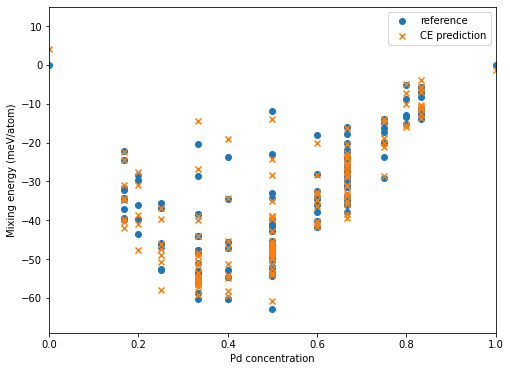

In [ ]:
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterExpansion

# step 1: Compile predicted and reference data for plotting
ce = ClusterExpansion.read('mixing_energy.ce')
data = {'concentration': [], 'reference_energy': [], 'predicted_energy': []}
db = connect('reference_data.db')
for row in db.select('natoms<=6'):
    data['concentration'].append(row.concentration)
    # the factor of 1e3 serves to convert from eV/atom to meV/atom
    data['reference_energy'].append(1e3 * row.mixing_energy)
    data['predicted_energy'].append(1e3 * ce.predict(row.toatoms()))

# step 2: Plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'Pd concentration')
ax.set_ylabel(r'Mixing energy (meV/atom)')
ax.set_xlim([0, 1])
ax.set_ylim([-69, 15])
ax.scatter(data['concentration'], data['reference_energy'],
           marker='o', label='reference')
ax.scatter(data['concentration'], data['predicted_energy'],
           marker='x', label='CE prediction')
ax.legend()
plt.savefig('mixing_energy_comparison.png', bbox_inches='tight')


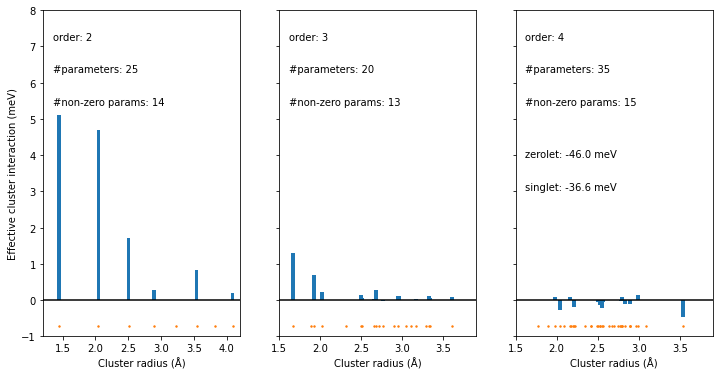

In [ ]:
import matplotlib.pyplot as plt
from icet import ClusterExpansion
import numpy as np

# step 1: Collect ECIs in dictionary
ce = ClusterExpansion.read('mixing_energy.ce')
df_ecis = ce.to_dataframe()

# step 2: Plot ECIs
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
for k, order in enumerate(ce.orders):
    df_order = df_ecis.loc[df_ecis['order'] == order]
    if k < 2 or k > 4:
        continue
    ax = axs[k - 2]
    ax.set_ylim((-1, 8))
    ax.set_xlabel(r'Cluster radius (Å)')
    if order == 2:
        ax.set_xlim((1.2, 4.2))
        ax.set_ylabel(r'Effective cluster interaction (meV)')
    if order == 3:
        ax.set_xlim((1.5, 3.9))
    if order == 4:
        ax.set_xlim((1.5, 3.9))
        ax.text(0.05, 0.55, 'zerolet: {:.1f} meV'
                .format(1e3 * df_ecis.eci.iloc[0]),
                transform=ax.transAxes)
        ax.text(0.05, 0.45, 'singlet: {:.1f} meV'
                .format(1e3 * df_ecis.eci.iloc[1]),
                transform=ax.transAxes)
    ax.plot([0, 5], [0, 0], color='black')
    ax.bar(df_order.radius, 1e3 * df_order.eci, width=0.05)
    ax.scatter(df_order.radius, len(df_order) * [-0.7],
               marker='o', s=2.0)
    ax.text(0.05, 0.91, 'order: {}'.format(order),
            transform=ax.transAxes)
    ax.text(0.05, 0.81, '#parameters: {}'.format(len(df_order)),
            transform=ax.transAxes,)
    ax.text(0.05, 0.71, '#non-zero params: {}'
            .format(np.count_nonzero(df_order.eci)),
            transform=ax.transAxes,)
plt.savefig('ecis.png', bbox_inches='tight')

In [ ]:
from ase.build import make_supercell
from icet import ClusterExpansion
from mchammer.calculators import ClusterExpansionCalculator
from mchammer.ensembles import SemiGrandCanonicalEnsemble
import numpy as np
from os import mkdir

# step 1: Set up structure to simulate as well as calculator
ce = ClusterExpansion.read('mixing_energy.ce')
structure = make_supercell(ce.get_cluster_space_copy().primitive_structure,
                           3 * np.array([[-1, 1, 1],
                                         [1, -1, 1],
                                         [1, 1, -1]]))
calculator = ClusterExpansionCalculator(structure, ce)

# step 2: Carry out Monte Carlo simulations
# Make sure output directory exists
output_directory = 'monte_carlo_data'
try:
    mkdir(output_directory)
except FileExistsError:
    pass
for temperature in [900, 300]:
    # Evolve configuration through the entire composition range
    for dmu in np.arange(-0.7, 0.51, 0.05):
        # Initialize MC ensemble
        mc = SemiGrandCanonicalEnsemble(
            structure=structure,
            calculator=calculator,
            temperature=temperature,
            dc_filename='{}/sgc-T{}-dmu{:+.3f}.dc'.format(output_directory, temperature, dmu),
            chemical_potentials={'Ag': 0, 'Pd': dmu})

        mc.run(number_of_trial_steps=len(structure) * 30)
        structure = mc.structure
from ase.build import make_supercell
from icet import ClusterExpansion
from mchammer.calculators import ClusterExpansionCalculator
from mchammer.ensembles import VCSGCEnsemble
import numpy as np
from os import mkdir

# step 1: Set up structure to simulate as well as calculator
ce = ClusterExpansion.read('mixing_energy.ce')
structure = make_supercell(ce.get_cluster_space_copy().primitive_structure,
                           3 * np.array([[-1, 1, 1],
                                         [1, -1, 1],
                                         [1, 1, -1]]))
calculator = ClusterExpansionCalculator(structure, ce)

# step 2: Carry out Monte Carlo simulations
# Make sure output directory exists
output_directory = 'monte_carlo_data'
try:
    mkdir(output_directory)
except FileExistsError:
    pass
for temperature in [900, 300]:
    # Evolve configuration through the entire composition range
    for phi in np.arange(-2.1, 0.11, 0.08):
        # Initialize MC ensemble
        mc = VCSGCEnsemble(
            structure=structure,
            calculator=calculator,
            temperature=temperature,
            dc_filename='{}/vcsgc-T{}-phi{:+.3f}.dc'.format(output_directory, temperature, phi),
            phis={'Pd': phi},
            kappa=200)

        mc.run(number_of_trial_steps=len(structure) * 30)
        structure = mc.structure

icet: WARNING  The ClusterExpansionCalculator self-interacts, which may lead to erroneous results. To avoid self-interaction, use a larger supercell or a cluster space with shorter cutoffs.
icet: WARNING  The ClusterExpansionCalculator self-interacts, which may lead to erroneous results. To avoid self-interaction, use a larger supercell or a cluster space with shorter cutoffs.


In [ ]:
import pandas as pd
from glob import glob
from mchammer import DataContainer

# step 1: Collect data from SGC and VCSGC simulations
for ensemble in ['sgc', 'vcsgc']:
    data = []
    for filename in glob('monte_carlo_data/{}-*.dc'.format(ensemble)):
        dc = DataContainer.read(filename)
        data_row = dc.ensemble_parameters
        data_row['filename'] = filename
        n_atoms = data_row['n_atoms']

        equilibration = 5 * n_atoms

        stats = dc.analyze_data('Pd_count', start=equilibration)
        data_row['Pd_concentration'] = stats['mean'] / n_atoms
        data_row['Pd_concentration_error'] = stats['error_estimate'] / n_atoms

        stats = dc.analyze_data('potential', start=equilibration)
        data_row['mixing_energy'] = stats['mean'] / n_atoms
        data_row['mixing_energy_error'] = stats['error_estimate'] / n_atoms

        data_row['acceptance_ratio'] = \
            dc.get_average('acceptance_ratio', start=equilibration)
        if ensemble == 'sgc':
            data_row['free_energy_derivative'] = \
                dc.ensemble_parameters['mu_Pd'] - \
                dc.ensemble_parameters['mu_Ag']
        elif ensemble == 'vcsgc':
            data_row['free_energy_derivative'] = \
                dc.get_average('free_energy_derivative_Pd', start=equilibration)

        data.append(data_row)

    # step 2: Write data to pandas dataframe in csv format
    df = pd.DataFrame(data)
    df.to_csv('monte-carlo-{}.csv'.format(ensemble), sep='\t')

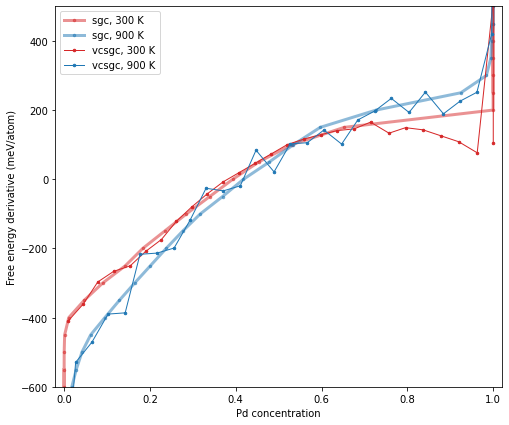

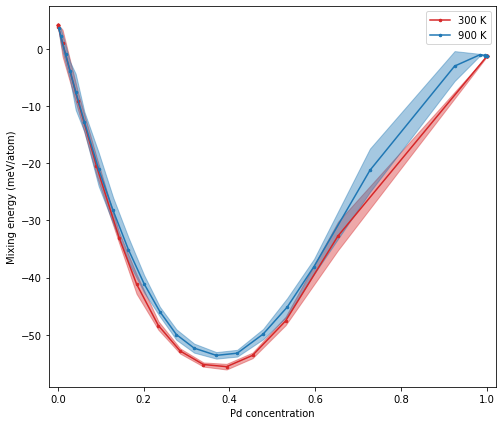

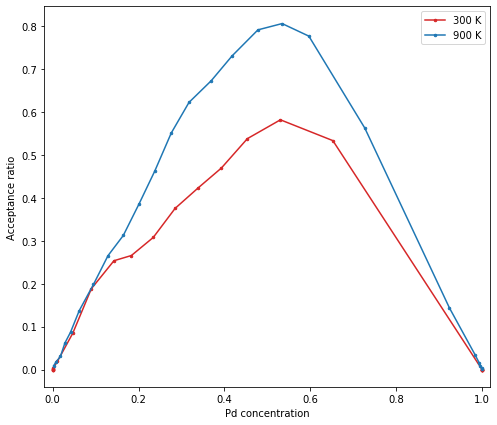

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# step 1: Load data frame
dfs = {}
dfs['sgc'] = pd.read_csv('monte-carlo-sgc.csv', delimiter='\t')
dfs['vcsgc'] = pd.read_csv('monte-carlo-vcsgc.csv', delimiter='\t')


# step 1: Plot free energy derivatives
colors = {300: '#D62728',  # red
          900: '#1F77B4'}  # blue
linewidths = {'sgc': 3, 'vcsgc': 1}
alphas = {'sgc': 0.5, 'vcsgc': 1.0}
fig, ax = plt.subplots(figsize=(8, 7))
for ensemble, df in dfs.items():
    for T in sorted(df.temperature.unique()):
        df_T = df.loc[df['temperature'] == T].sort_values('Pd_concentration')
        ax.plot(df_T['Pd_concentration'],
                1e3 * df_T['free_energy_derivative'],
                marker='o', markersize=2.5,
                label='{}, {} K'.format(ensemble, T),
                color=colors[T],
                linewidth=linewidths[ensemble], alpha=alphas[ensemble])
ax.set_xlabel('Pd concentration')
ax.set_ylabel('Free energy derivative (meV/atom)')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-600, 500])
ax.legend()
plt.savefig('free_energy_derivative.png', bbox_inches='tight')

# step 2: Plot mixing energy vs composition
df = dfs['sgc']
fig, ax = plt.subplots(figsize=(8, 7))
for T in sorted(df.temperature.unique()):
    df_T = df.loc[df['temperature'] == T].sort_values('Pd_concentration')
    e_mix = 1e3 * df_T['mixing_energy']
    e_mix_error = 1e3 * df_T['mixing_energy_error']
    ax.plot(df_T['Pd_concentration'], e_mix,
            marker='o', markersize=2.5, label='{} K'.format(T),
            color=colors[T])
    # Plot error estimate
    ax.fill_between(df_T['Pd_concentration'],
                    e_mix + e_mix_error, e_mix - e_mix_error,
                    color=colors[T], alpha=0.4)
ax.set_xlabel('Pd concentration')
ax.set_ylabel('Mixing energy (meV/atom)')
ax.set_xlim([-0.02, 1.02])
ax.legend()
plt.savefig('mixing_energy_sgc.png', bbox_inches='tight')

# step 3: Plot acceptance ratio vs composition
df = dfs['sgc']
fig, ax = plt.subplots(figsize=(8, 7))
for T in sorted(df.temperature.unique()):
    df_T = df.loc[df['temperature'] == T].sort_values('Pd_concentration')
    ax.plot(df_T['Pd_concentration'], df_T['acceptance_ratio'],
            marker='o', markersize=2.5, label='{} K'.format(T),
            color=colors[T])
ax.set_xlabel('Pd concentration')
ax.set_ylabel('Acceptance ratio')
ax.set_xlim([-0.02, 1.02])
ax.legend()
plt.savefig('acceptance_ratio_sgc.png', bbox_inches='tight')